<a href="https://colab.research.google.com/github/yumpy/sandbox/blob/master/pharmapsychotic_Stable_Diffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stable Diffusion notebook by [@pharmapsychotic](https://twitter.com/pharmapsychotic)

This let's you generate images with CompVis/Stability [Stable Diffusion](https://github.com/CompVis/stable-diffusion) with bonus [KLMS sampling](https://github.com/crowsonkb/k-diffusion.git) from [@RiversHaveWings](https://twitter.com/RiversHaveWings)

You need to get the ckpt file and put it on your Google Drive first to use this. It can be downloaded from [HuggingFace](https://huggingface.co/CompVis/stable-diffusion).

Other Stable Diffusion tools:
* [Deforum Stable Diffusion](https://colab.research.google.com/github/deforum/stable-diffusion/blob/main/Deforum_Stable_Diffusion.ipynb) by [deforum_art](https://twitter.com/deforum_art) team
* [HuggingFace space for Stable Diffusion](https://huggingface.co/spaces/stabilityai/stable-diffusion)
* [Stable Diffusion Interpolation](https://colab.research.google.com/drive/1EHZtFjQoRr-bns1It5mTcOVyZzZD9bBc?usp=sharing) by [@ygantigravity](https://twitter.com/ygantigravity)
* [Stable Diffusion with diffusers](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/stable_diffusion.ipynb#scrollTo=zHkHsdtnry57)
* [Prompt-space Interpolation](https://colab.research.google.com/drive/1gj8_EPyntZuaiQuzYOzog5YKA74esoB3#scrollTo=3g5rSm43STsW) by [@DigThatData](https://twitter.com/DigThatData)
* [Stable Diffusion Lite](https://colab.research.google.com/drive/1cl3d84B5AXepycKAfCba77faUFBRGY2O?usp=sharing#scrollTo=Rn06QzsdsICR) by [@future__art](https://twitter.com/future__art)
* More to come!!

If you're looking for more Ai art tools check out my [Ai generative art tools list](https://pharmapsychotic.com/tools.html).


In [1]:
#@title Check GPU
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-d75b24e0-f31d-e653-811c-8bebee9a8cad)


In [2]:
#@title Mount Google Drive and Prepare Folders
from google.colab import drive
drive.mount('/content/gdrive')
outputs_path = "/content/gdrive/MyDrive/AI/StableDiffusion"
!mkdir -p $outputs_path
print(f"Outputs will be saved to {outputs_path}")

Mounted at /content/gdrive
Outputs will be saved to /content/gdrive/MyDrive/AI/StableDiffusion


In [3]:
#@title Installation
!pip install pytorch-lightning torch-fidelity
!pip install numpy omegaconf einops kornia pytorch-lightning
!pip install albumentations transformers
!pip install ftfy jsonmerge resize-right torchdiffeq tqdm

!git clone https://github.com/CompVis/stable-diffusion
!git clone https://github.com/CompVis/taming-transformers
!git clone https://github.com/openai/CLIP.git
!git clone https://github.com/crowsonkb/k-diffusion.git

!echo '' > ./k-diffusion/k_diffusion/__init__.py


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 705 kB 24.1 MB/s 
     |████████████████████████████████| 5.9 MB 53.8 MB/s 
     |████████████████████████████████| 419 kB 71.6 MB/s 
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.2+zzzcolab20220719082949 requires tensorboard<2.9,>=2.8, but you have tensorboard 2.10.0 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 79 kB 7.5 MB/s 
     |████████████████████████████████| 565 kB 62.1 MB/s 
     |████████████████████████████████| 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 32.0 MB/s 
     |████████████████████████████████| 6.6 MB 60.0 MB/s 
     |████████████████████████████████| 120 kB 57.7 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 53 kB 1.6 MB/s 
  Created wheel for jsonmerge: filename=jsonmerge-1.8.0-py3-none-any.whl size=18013 sha256=003382786acaf3a4fe6f25856cf444a6d96c5125ad226da9d1152930b3d7c974
  Stored in directory: /root/.cache/pip/wheels/2f/c8/79/83ddc70e0b20f2df3bbac658c2c5d665b76cedd02e67bd61dc
Successfully built jsonmerge
Cloning into 'stable-diffusion'...
remote: Enumerating objects: 313, done.
remote: Total 313 (delta 0), reused 0 (delta 0), pack-reused 313
Receiving objects: 100% (313/313), 42.62 MiB | 16.77 MiB/s, done.
Resolving deltas: 100% (114/114), done.
Cloning into 'taming-transformers'

In [4]:
#@title Load Model

#@markdown You need to get the model weights yourself and put on Google Drive or this Colab instance
checkpoint_model_file = "/content/gdrive/MyDrive/AI/models/sd-v1-4.ckpt" #@param {type:"string"}

import argparse, gc, json, os, random, sys, time, glob, requests
import torch
import torch.nn as nn
import numpy as np
import PIL
from contextlib import contextmanager, nullcontext
from einops import rearrange, repeat
from IPython.display import display, clear_output
from itertools import islice
from omegaconf import OmegaConf
from PIL import Image
from pytorch_lightning import seed_everything
from torch import autocast

sys.path.append("./CLIP")
sys.path.append('./k-diffusion')
sys.path.append('./stable-diffusion')
sys.path.append('./taming-transformers')

from ldm.util import instantiate_from_config
from ldm.models.diffusion.ddim import DDIMSampler
from ldm.models.diffusion.plms import PLMSSampler

from k_diffusion.sampling import sample_lms
from k_diffusion.external import CompVisDenoiser

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

class config():
    def __init__(self):
        self.ckpt = checkpoint_model_file
        self.config = 'stable-diffusion/configs/stable-diffusion/v1-inference.yaml'
        self.ddim_eta = 0.0
        self.ddim_steps = 100
        self.fixed_code = True
        self.init_img = None
        self.n_samples = 1
        self.outdir = ""
        self.precision = 'autocast'
        self.prompt = ""
        self.sampler = 'klms'
        self.scale = 7.5
        self.seed = 42
        self.strength = 0.75 # strength for noising/unnoising. 1.0 corresponds to full destruction of information in init image
        self.H = 512
        self.W = 512
        self.C = 4
        self.f = 8

class CFGDenoiser(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.inner_model = model

    def forward(self, x, sigma, uncond, cond, cond_scale):
        x_in = torch.cat([x] * 2)
        sigma_in = torch.cat([sigma] * 2)
        cond_in = torch.cat([uncond, cond])
        uncond, cond = self.inner_model(x_in, sigma_in, cond=cond_in).chunk(2)
        return uncond + (cond - uncond) * cond_scale

def load_model_from_config(config, ckpt, verbose=False):
    print(f"Loading model from {ckpt}")
    pl_sd = torch.load(ckpt, map_location="cpu")
    if "global_step" in pl_sd:
        print(f"Global Step: {pl_sd['global_step']}")
    sd = pl_sd["state_dict"]
    model = instantiate_from_config(config.model)
    m, u = model.load_state_dict(sd, strict=False)
    if len(m) > 0 and verbose:
        print("missing keys:")
        print(m)
    if len(u) > 0 and verbose:
        print("unexpected keys:")
        print(u)

    model = model.half().to(device)
    model.eval()
    return model
      
def load_img(path, shape):
    if path.startswith('http://') or path.startswith('https://'):
        image = Image.open(requests.get(path, stream=True).raw).convert('RGB')
    else:
        if os.path.isdir(path):
            files = [file for file in os.listdir(path) if file.endswith('.png') or file .endswith('.jpg')]
            path = os.path.join(path, random.choice(files))
            print(f"Chose random init image {path}")
        image = Image.open(path).convert('RGB')
    image = image.resize(shape, resample=PIL.Image.LANCZOS)
    image = np.array(image).astype(np.float16) / 255.0
    image = image[None].transpose(0, 3, 1, 2)
    image = torch.from_numpy(image)
    return 2.*image - 1.

opt = config()
config = OmegaConf.load(f"{opt.config}")
model = load_model_from_config(config, f"{opt.ckpt}")
model = model.to(device)
batch_idx = 0
sample_idx = 0

def generate(opt):
    global sample_idx
    seed_everything(opt.seed)
    os.makedirs(opt.outdir, exist_ok=True)

    if opt.sampler == 'plms':
        sampler = PLMSSampler(model)
    else:
        sampler = DDIMSampler(model)

    model_wrap = CompVisDenoiser(model)       
    batch_size = opt.n_samples
    prompt = opt.prompt
    assert prompt is not None
    data = [batch_size * [prompt]]
    init_latent = None

    if opt.init_img != None and opt.init_img != '':
        init_image = load_img(opt.init_img, shape=(opt.W, opt.H)).to(device)
        init_image = repeat(init_image, '1 ... -> b ...', b=batch_size)
        init_latent = model.get_first_stage_encoding(model.encode_first_stage(init_image))  # move to latent space

    sampler.make_schedule(ddim_num_steps=opt.ddim_steps, ddim_eta=opt.ddim_eta, verbose=False)

    t_enc = int(opt.strength * opt.ddim_steps)

    start_code = None
    if opt.fixed_code and init_latent == None:
        start_code = torch.randn([opt.n_samples, opt.C, opt.H // opt.f, opt.W // opt.f], device=device)

    images = []
    precision_scope = autocast if opt.precision == "autocast" else nullcontext
    with torch.no_grad():
        with precision_scope("cuda"):
            with model.ema_scope():
                for prompts in data:
                    uc = None
                    if opt.scale != 1.0:
                        uc = model.get_learned_conditioning(batch_size * [""])
                    if isinstance(prompts, tuple):
                        prompts = list(prompts)
                    c = model.get_learned_conditioning(prompts)

                    if init_latent != None:
                        z_enc = sampler.stochastic_encode(init_latent, torch.tensor([t_enc]*batch_size).to(device))
                        samples = sampler.decode(z_enc, c, t_enc, unconditional_guidance_scale=opt.scale,
                                                unconditional_conditioning=uc,)
                    else:

                        if opt.sampler == 'klms':
                            print("Using KLMS sampling")
                            shape = [opt.C, opt.H // opt.f, opt.W // opt.f]
                            sigmas = model_wrap.get_sigmas(opt.ddim_steps)
                            model_wrap_cfg = CFGDenoiser(model_wrap)
                            x = torch.randn([opt.n_samples, *shape], device=device) * sigmas[0]
                            extra_args = {'cond': c, 'uncond': uc, 'cond_scale': opt.scale}
                            samples = sample_lms(model_wrap_cfg, x, sigmas, extra_args=extra_args, disable=False)
                        else:
                            shape = [opt.C, opt.H // opt.f, opt.W // opt.f]
                            samples, _ = sampler.sample(S=opt.ddim_steps,
                                                            conditioning=c,
                                                            batch_size=opt.n_samples,
                                                            shape=shape,
                                                            verbose=False,
                                                            unconditional_guidance_scale=opt.scale,
                                                            unconditional_conditioning=uc,
                                                            eta=opt.ddim_eta,
                                                            x_T=start_code)

                    x_samples = model.decode_first_stage(samples)
                    x_samples = torch.clamp((x_samples + 1.0) / 2.0, min=0.0, max=1.0)

                    for x_sample in x_samples:
                        x_sample = 255. * rearrange(x_sample.cpu().numpy(), 'c h w -> h w c')
                        images.append(Image.fromarray(x_sample.astype(np.uint8)))
                        filepath = os.path.join(opt.outdir, f"{batch_name}({batch_idx})_{sample_idx:04}.png")
                        print(f"Saving to {filepath}")
                        Image.fromarray(x_sample.astype(np.uint8)).save(filepath)
                        sample_idx += 1
    return images


Loading model from /content/gdrive/MyDrive/AI/models/sd-v1-4.ckpt
Global Step: 470000
LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 859.52 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels


Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.8.mlp.fc1.weight', 'vision_model.encoder.layers.23.layer_norm2.bias', 'vision_model.encoder.layers.17.layer_norm1.bias', 'vision_model.encoder.layers.17.self_attn.out_proj.weight', 'vision_model.encoder.layers.10.mlp.fc2.weight', 'vision_model.encoder.layers.16.layer_norm2.weight', 'vision_model.encoder.layers.2.layer_norm1.bias', 'vision_model.encoder.layers.14.self_attn.q_proj.bias', 'vision_model.encoder.layers.4.self_attn.out_proj.weight', 'vision_model.encoder.layers.13.mlp.fc1.weight', 'vision_model.encoder.layers.4.self_attn.v_proj.weight', 'vision_model.encoder.layers.4.self_attn.q_proj.bias', 'vision_model.encoder.layers.13.self_attn.k_proj.weight', 'vision_model.encoder.layers.14.self_attn.k_proj.bias', 'vision_model.encoder.layers.20.self_attn.v_proj.weight', 'vision_model.encoder.layers.20.mlp.fc1.weight', 'vision_model.encoder.l

Used seed: 4086522133
Saved to: /content/gdrive/MyDrive/AI/StableDiffusion/20220831_Mice


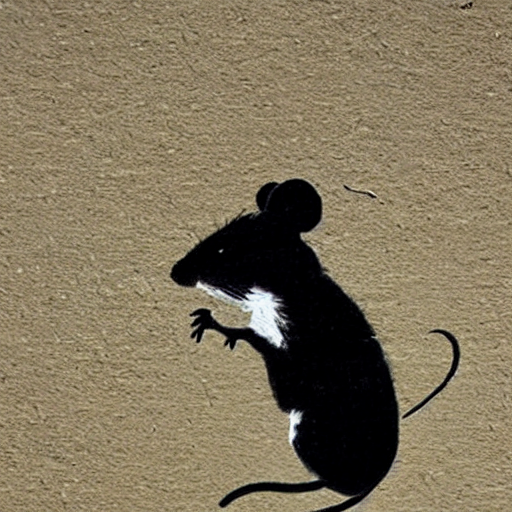

In [29]:
#@title Image creation

#@markdown `batch_name`: name for subfolder and filenames<br>
#@markdown `width_height`: image dimensions<br>
#@markdown `guidance_scale`: strength of text prompt<br>
#@markdown `steps`: number of diffusion steps<br>
#@markdown `num_batch_images`: how many images you want to generate in this batch<br>
#@markdown `sampler`: KLMS is recommended<br>
#@markdown `ddim_eta`: scale of variance from 0.0 to 1.0<br>
#@markdown `seed`: use -1 for random seed or specify number manually<br>
#@markdown `init_image_or_folder`: url or path to an image, or path to a folder to pick random images from<br>
#@markdown `init_strength`: from 0.0 to 1.0 how much the init image is used<br>

#@markdown 

#@markdown Batch settings
batch_name = "20220831_Mice" #@param {type:"string"}
width_height = [512, 512] #@param{type: 'raw'}
guidance_scale = 7.5 #@param {type:"number"}
steps = 100 #@param {type:"integer"}
samples_per_batch = 1 # not exposed, you can do 2 or more based on GPU ram, if get CUDA out of memory need to restart runtime
num_batch_images = 1 #@param {type:"integer"}
sampler = 'klms' #@param ["klms","plms", "ddim"]
ddim_eta = 0.75 #@param {type:"number"}
seed = -1 #@param {type:"integer"}

#@markdown 

#@markdown Init image


init_image_or_folder = "/content/gdrive/MyDrive/AI/StableDiffusion/20220831_Mice/init_image/angry_mouse.png" #@param {type:"string"}
init_strength = 0.0 #@param {type:"number"}

#@markdown 

#@markdown Prompt
prompt = "An angry mouse sitting on a window sill, its fur on end, its tail twitching. In the style of Banksy" #@param {type:"string"}


opt.ddim_eta = ddim_eta
opt.ddim_steps = steps
opt.init_img = init_image_or_folder
opt.n_samples = samples_per_batch
opt.outdir = os.path.join(outputs_path, batch_name)
opt.prompt = prompt
opt.sampler = sampler
opt.scale = guidance_scale
opt.seed = random.randint(0, 2**32) if seed == -1 else seed
opt.strength = max(0.0, min(1.0, 1.0 - init_strength))
opt.W, opt.H = map(lambda x: x - x % 64, (width_height[0], width_height[1])) # resize to integer multiple of 64

if opt.strength >= 1 or init_image_or_folder == None:
    opt.init_img = ""

if opt.init_img != None and opt.init_img != '':
    opt.sampler = 'ddim'

if opt.sampler != 'ddim':
    opt.ddim_eta = 0.0

# save settings
settings = {
    'ddim_eta': ddim_eta,
    'guidance_scale': guidance_scale,
    'init_image': init_image_or_folder,
    'init_strength': init_strength,
    'num_batch_images': num_batch_images,
    'prompt': prompt,
    'sampler': sampler,
    'samples_per_batch': samples_per_batch,
    'seed': opt.seed,
    'steps': steps,
    'width': opt.W,
    'height': opt.H,
}
os.makedirs(opt.outdir, exist_ok=True)
while os.path.isfile(f"{opt.outdir}/{batch_name}({batch_idx})_settings.txt"):
    batch_idx += 1
with open(f"{opt.outdir}/{batch_name}({batch_idx})_settings.txt", "w+", encoding="utf-8") as f:
    json.dump(settings, f, ensure_ascii=False, indent=4)
sample_idx = 0

for i in range(num_batch_images):
    gc.collect()
    torch.cuda.empty_cache()

    images = generate(opt)

    clear_output(wait=True)
    print(f"Used seed: {opt.seed}")
    print(f"Saved to: {opt.outdir}")
    for image in images:
        display(image)

    opt.seed += 1
